# Exploratory Data Analysis for NFL Win Probability Model

## Introduction


# Data Preparation

## Analyzing the Reference Calibration Data

The first step to building the win probability model is to analyze the reference calibration data.  This will be used as a reference that can validate the efficacy of the calibration codebase.  The following test cases are currently supported:

1. Test that the calibration data has the correct number of rows and columns.
2. Test that the calibration data has the correct column names.
3. Test that the calibration data has the correct data types.
4. Test that the calibration data has the correct number of missing values.

The slightest mistake in the calibration logic can taint the dataset, so the tests are managed and run using pytest in `tests/validation/test_calibration.py`.

### Import Reference Calibration Data

The Reference calibration data can be found [here](https://raw.githubusercontent.com/guga31bb/metrics/master/wp_tuning/cal_data.rds).  To validate the data, I will save it as a CSV, and then generate the test calibration data and save that to a CSV as well:

In [1]:
# Auto reloads updated modules
%load_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings('ignore')

In [2]:
from utils.data_utils import REFERENCE_CAL_DATA_URL, import_rds, save_to_csv


REFERENCE_CAL_DATA_RDS_PATH = 'tests/validation/calibration_data/cal_data.rds'
REFERENCE_CAL_DATA_CSV_PATH = 'tests/validation/calibration_data/reference_cal_data.csv'
CAL_DATA_PATH = 'tests/validation/calibration_data/cal_data.csv'

reference_cal_data = import_rds(REFERENCE_CAL_DATA_URL, REFERENCE_CAL_DATA_RDS_PATH)

# save reference calibration data to CSV
save_to_csv(reference_cal_data, REFERENCE_CAL_DATA_CSV_PATH)

### Generate Test Calibration Data

In [3]:
from utils.data_utils import import_pbp_data
from utils.calibration import create_wp_calibration_data

# import PBP data
start =1999
end = 2023

pbp_data = import_pbp_data(start, end)
cal_data = create_wp_calibration_data(pbp_data)

dtypes = reference_cal_data.dtypes.to_dict()
cal_data = cal_data.astype(dtypes)

source_cal_data = cal_data.copy()

# Select specific columns
cal_data = cal_data[[
    'game_id', 'play_type', 'game_seconds_remaining', 'half_seconds_remaining', 'yardline_100', 'roof',
    'posteam', 'defteam', 'home_team', 'ydstogo', 'season', 'qtr', 'down', 'week', 'drive', 'ep',
    'score_differential', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'desc', 'Winner',
    'spread_line', 'total_line'
]]

# create test calibration data that matches reference calibration data set
ref_start = reference_cal_data['season'].min()
ref_end = reference_cal_data['season'].max()
test_cal_data = cal_data.loc[(cal_data['season'] >= ref_start) & (cal_data['season'] <= ref_end)]

# save test calibration data to CSV
save_to_csv(test_cal_data, CAL_DATA_PATH)

Downcasting floats.


### Validate the Calibration Data

In [4]:
!source ~/.virtualenvs/nfl-data-models/bin/activate && pytest tests/validation/test_calibration_data.py -v

============================= test session starts ==============================
platform linux -- Python 3.10.12, pytest-8.0.0, pluggy-1.3.0 -- /home/dev/.virtualenvs/nfl-data-models/bin/python
cachedir: .pytest_cache
rootdir: /mnt/c/Users/Jonathan Bailey/PycharmProjects/nfl-data-models
configfile: setup.cfg
plugins: anyio-4.0.0, dash-2.14.2
collected 4 items                                                              

tests/validation/test_calibration_data.py::TestWPCalDataValidation::test_compare_column_types_to_reference PASSED [ 25%]
tests/validation/test_calibration_data.py::TestWPCalDataValidation::test_compare_columns_to_reference PASSED [ 50%]
tests/validation/test_calibration_data.py::TestWPCalDataValidation::test_compare_missing_values_in_each_column_to_reference PASSED [ 75%]
tests/validation/test_calibration_data.py::TestWPCalDataValidation::test_compare_shape_to_reference PASSED [100%]

============================== 4 passed in 3.49s ===============================


As soon as the validation passes, we can now use `cal_data` (it contains complete, current calibration data from 1999-2023) to build the win probability model in the next step.

### Preprocessing the Calibration Data

Additional preprocessing is done:
1. make_model_mutations: This function creates new features and modifies existing ones to better suit the model.
2. prepare_wp_data: This function prepares the data for the win probability model by filtering out irrelevant columns and renaming the remaining ones.
3. add_label_column: This function adds a label column to the data, indicating whether the home team won or lost.
4. drop_rows: This function drops rows with missing values, ties, and non regular time periods (ie overtime).
5. Filter columns to only include those relevant to the win probability model.

In [5]:
from utils.calibration import (
    make_model_mutations,
    prepare_wp_data,
    add_label_column,
    drop_rows
)

cal_data = make_model_mutations(source_cal_data)
cal_data = prepare_wp_data(cal_data)
cal_data = add_label_column(cal_data)
cal_data = drop_rows(cal_data)
cal_data = cal_data.loc[cal_data['Winner'] != 'TIE']

WP_CAL_DATA_COLS = ['game_id', 'label', 'receive_2h_ko', 'spread_time', 'home', 'half_seconds_remaining', 'game_seconds_remaining', 'Diff_Time_Ratio', 'score_differential', 'down', 'ydstogo', 'yardline_100', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'season']
cal_data = cal_data[WP_CAL_DATA_COLS]

cal_data.head()

,game_id,label,receive_2h_ko,spread_time,home,half_seconds_remaining,game_seconds_remaining,Diff_Time_Ratio,score_differential,down,ydstogo,yardline_100,posteam_timeouts_remaining,defteam_timeouts_remaining,season
1,1999_01_ARI_PHI,0,0,-3.0,1,1800.0,3600.0,0.0,0.0,1.0,10.0,77.0,3.0,3.0,1999
2,1999_01_ARI_PHI,0,0,-3.0,1,1800.0,3600.0,0.0,0.0,2.0,10.0,77.0,3.0,3.0,1999
3,1999_01_ARI_PHI,0,0,-3.0,1,1800.0,3600.0,0.0,0.0,3.0,9.0,76.0,3.0,3.0,1999
4,1999_01_ARI_PHI,0,0,-3.0,1,1800.0,3600.0,0.0,0.0,3.0,14.0,81.0,3.0,3.0,1999
5,1999_01_ARI_PHI,0,0,-3.0,1,1800.0,3600.0,0.0,0.0,4.0,4.0,71.0,3.0,3.0,1999


The data is now ready for training.

## Model 1: Using Reference Parameters, including Monotone Constraints

The parameters used are located within this objective function [here](https://github.com/nflverse/nflfastR/blob/8df5c6b7dc0ad43f78da2a3b0b9c7957e399f182/data-raw/MODELS.R#L169-L183).  In addition to these parameters, I chose to train this model using GPU hardware, so the configuration will slightly diverge from the reference configuration, but it shouldn't make a difference:

1. booster: gbtree - The booster type used for training.
2. device: cuda - The device used for training.
3. objective: binary:logistic - Binary Classification task using boosted trees.  This is extremely useful for non-gaussian data, which the PBP dataset most certainly is not gaussian.
4. eval_metric: logloss - Negative-log-likelihood Loss function.
5. sampling_method: gradient_based - The method used to sample the training data.
6. early_stopping_rounds: 200 - The number of rounds without improvement before stopping the training.
7. eta: 0.05 - Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
8. gamma: 0.79012017 - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
9. subsample: 0.9224245 - Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting.
10. colsample_bytree: 5 / 12 - Subsample ratio of columns when constructing each tree.  Value seems to be `max_depth / num_features`.  Subsampling occurs once for every tree constructed.
11. max_depth: 5 - Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
12. min_child_weight: 7 - Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node.
13. monotone_constraints: *see below for the value.*  This is a dictionary where the keys are the feature names and the values are the constraints.  A constraint of 1 means the feature is increasing, -1 means the feature is decreasing, and 0 means no constraint.

```json
{
    "receive_2h_ko": 0,
    "spread_time": 0,
    "home": 0,
    "half_seconds_remaining": 0,
    "game_seconds_remaining": 0,
    "Diff_Time_Ratio": 1,
    "score_differential": 1,
    "down": -1,
    "ydstogo": -1,
    "yardline_100": -1,
    "posteam_timeouts_remaining": 1,
    "defteam_timeouts_remaining": -1
}
```

We will begin by performing cross validation on the data:

In [6]:
from sklearn.model_selection import GroupKFold
import xgboost as xgb
import numpy as np
import time


# set the RAPIDS memory manager
xgb.set_config(use_rmm=True)

monotone_contraints_df = {
    'receive_2h_ko': 0,
    'spread_time': 0,
    'home': 0,
    'half_seconds_remaining': 0,
    'game_seconds_remaining': 0,
    'Diff_Time_Ratio': 1,
    'score_differential': 1,
    'down': -1,
    'ydstogo': -1,
    'yardline_100': -1,
    'posteam_timeouts_remaining': 1,
    'defteam_timeouts_remaining': -1
}

params = {
    'booster': 'gbtree',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'grow_policy': 'lossguide',
    'sampling_method': 'gradient_based',
    'eta': 0.05,
    'gamma': 0.79012017,
    'subsample': 0.9224245,
    'colsample_bytree': 5 / 12,
    'max_depth': 5,
    'min_child_weight': 7,
    'monotone_constraints': monotone_contraints_df
}

X = cal_data.loc[:, ~cal_data.columns.isin(['season', 'game_id', 'label'])]
y = cal_data['label']
groups = cal_data['game_id']

dtrain = xgb.DMatrix(X, label=y)
folds = [(train_idx, test_idx) for train_idx, test_idx in GroupKFold(n_splits=10).split(X, y, groups=groups)]

cv_results = xgb.cv(
    params=params, 
    dtrain=dtrain, 
    num_boost_round=10000, 
    stratified=True, 
    folds=folds, 
    metrics=['auc', 'error', 'logloss'], 
    maximize=False, 
    early_stopping_rounds=50,
    shuffle=True,
    seed=42,
    verbose_eval=100
)

[0]	train-auc:0.70809+0.00253	train-error:0.35734+0.00673	train-logloss:0.68651+0.00011	test-auc:0.70658+0.01214	test-error:0.35958+0.00790	test-logloss:0.68657+0.00040
[100]	train-auc:0.86449+0.00090	train-error:0.22476+0.00091	train-logloss:0.45511+0.00133	test-auc:0.86318+0.00886	test-error:0.22557+0.00877	test-logloss:0.45700+0.01166
[200]	train-auc:0.86715+0.00083	train-error:0.22238+0.00085	train-logloss:0.44761+0.00126	test-auc:0.86530+0.00813	test-error:0.22388+0.00816	test-logloss:0.45072+0.01187
[300]	train-auc:0.86809+0.00082	train-error:0.22170+0.00080	train-logloss:0.44573+0.00124	test-auc:0.86584+0.00789	test-error:0.22355+0.00792	test-logloss:0.44961+0.01173
[400]	train-auc:0.86875+0.00081	train-error:0.22117+0.00081	train-logloss:0.44449+0.00122	test-auc:0.86614+0.00769	test-error:0.22343+0.00768	test-logloss:0.44906+0.01155
[500]	train-auc:0.86899+0.00082	train-error:0.22096+0.00084	train-logloss:0.44409+0.00122	test-auc:0.86619+0.00761	test-error:0.22335+0.00761	test-

In [7]:
cv_results.sort_values(by='test-logloss-mean')[['train-logloss-mean','test-logloss-mean','test-error-mean', 'test-auc-mean']]

,train-logloss-mean,test-logloss-mean,test-error-mean,test-auc-mean
454,0.444116,0.448959,0.223329,0.866190
453,0.444124,0.448959,0.223331,0.866191
451,0.444147,0.448967,0.223321,0.866185
452,0.444138,0.448968,0.223338,0.866184
450,0.444149,0.448968,0.223320,0.866185
...,...,...,...,...
4,0.661937,0.662105,0.265474,0.820804
3,0.662630,0.662790,0.266048,0.820388
2,0.679486,0.679609,0.336155,0.714739
1,0.680869,0.680981,0.337929,0.712969


Cross validation results show that the model's best log loss was 0.4489.  Let's train the model and test it against the 2023 season:

In [8]:
train_data = cal_data.loc[cal_data['season'] < 2023]
test_data = cal_data.loc[cal_data['season'] == 2023]

dtrain = xgb.DMatrix(train_data.loc[:, ~train_data.columns.isin(['season', 'game_id', 'label'])], label=train_data['label'])
dtest = xgb.DMatrix(test_data.loc[:, ~test_data.columns.isin(['season', 'game_id', 'label'])], label=test_data['label'])

bst = xgb.train(params=params, dtrain=dtrain, num_boost_round=10000, early_stopping_rounds=50, maximize=False, verbose_eval=100, evals=[(dtest, 'season2023')])

[0]	season2023-logloss:0.68695
[100]	season2023-logloss:0.45433
[200]	season2023-logloss:0.45010
[300]	season2023-logloss:0.44987
[368]	season2023-logloss:0.44992


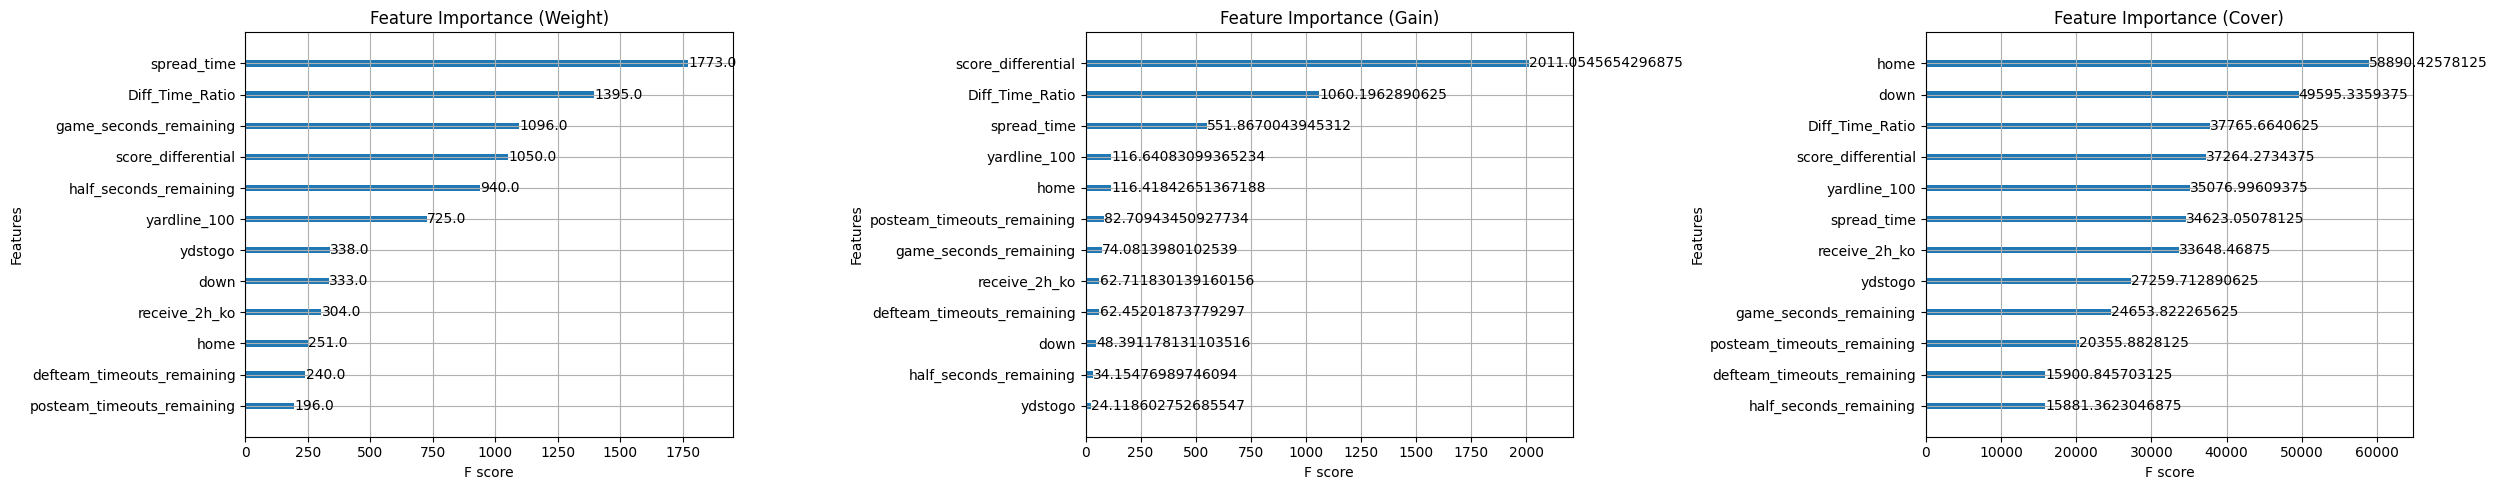

In [9]:
from matplotlib import pyplot as plt

xgb_plot = xgb.plot_importance

fig, ax = plt.subplots(1, 3, figsize=(25, 5))

xgb_plot(bst, importance_type='weight', ax=ax[0], title='Feature Importance (Weight)')
xgb_plot(bst, importance_type='gain', ax=ax[1], title='Feature Importance (Gain)')
xgb_plot(bst, importance_type='cover', ax=ax[2], title='Feature Importance (Cover)')

plt.tight_layout()

`spread_time` appeared 31% more often in trees across the ensemble of tree.  `score_differential` was responsible for tree splits due to error thresholds 20% more often.  I believe this tells us that the model believes that `spread_time` is more important for predicting when the home team will win, and `score_differential` is used as an indicator that the home team may lose.

Next, a final test of the model against the 2023 season will be performed:

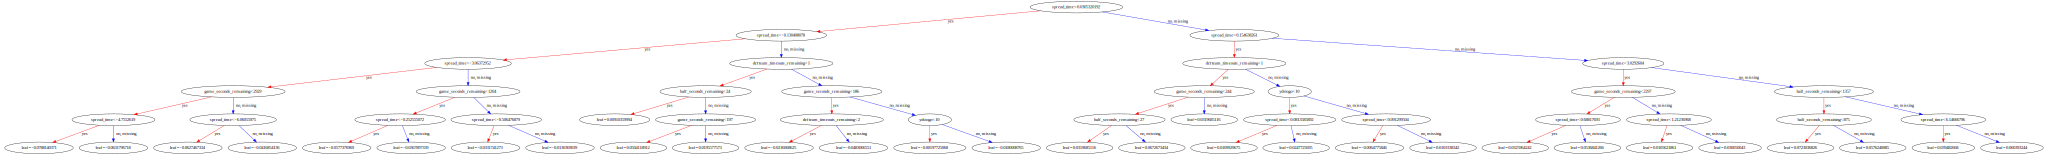

In [10]:
xgb.to_graphviz(bst)

In [11]:
pred_results = test_data[['game_id', 'label', 'score_differential']].copy()
pred_results['wp'] = bst.predict(dtest)
pred_results['pred_label'] = np.where(pred_results['wp'] > 0.5, 1, 0)
pred_results['margin'] = bst.predict(dtest, output_margin=True, pred_leaf=False, pred_contribs=False, approx_contribs=False, pred_interactions=False)
pred_leaf = bst.predict(dtest, output_margin=False, pred_leaf=True, pred_contribs=False, approx_contribs=False, pred_interactions=False)

pred_contrib = bst.predict(dtest, output_margin=False, pred_leaf=False, pred_contribs=True, approx_contribs=False, pred_interactions=False)
pred_interactions = bst.predict(dtest, output_margin=False, pred_leaf=False, pred_contribs=False, approx_contribs=False, pred_interactions=True)

pred_results

,game_id,label,score_differential,wp,pred_label,margin
1148719,2023_01_ARI_WAS,1,0.0,0.744501,1,1.069494
1148720,2023_01_ARI_WAS,1,0.0,0.714930,1,0.919448
1148721,2023_01_ARI_WAS,1,0.0,0.729753,1,0.993372
1148722,2023_01_ARI_WAS,1,0.0,0.739904,1,1.045469
1148723,2023_01_ARI_WAS,1,0.0,0.728034,1,0.984670
...,...,...,...,...,...,...
1198168,2023_21_KC_BAL,1,7.0,0.935539,1,2.675058
1198170,2023_21_KC_BAL,1,7.0,0.950605,1,2.957255
1198171,2023_21_KC_BAL,1,7.0,0.988768,1,4.477696
1198172,2023_21_KC_BAL,1,7.0,0.993683,1,5.058116


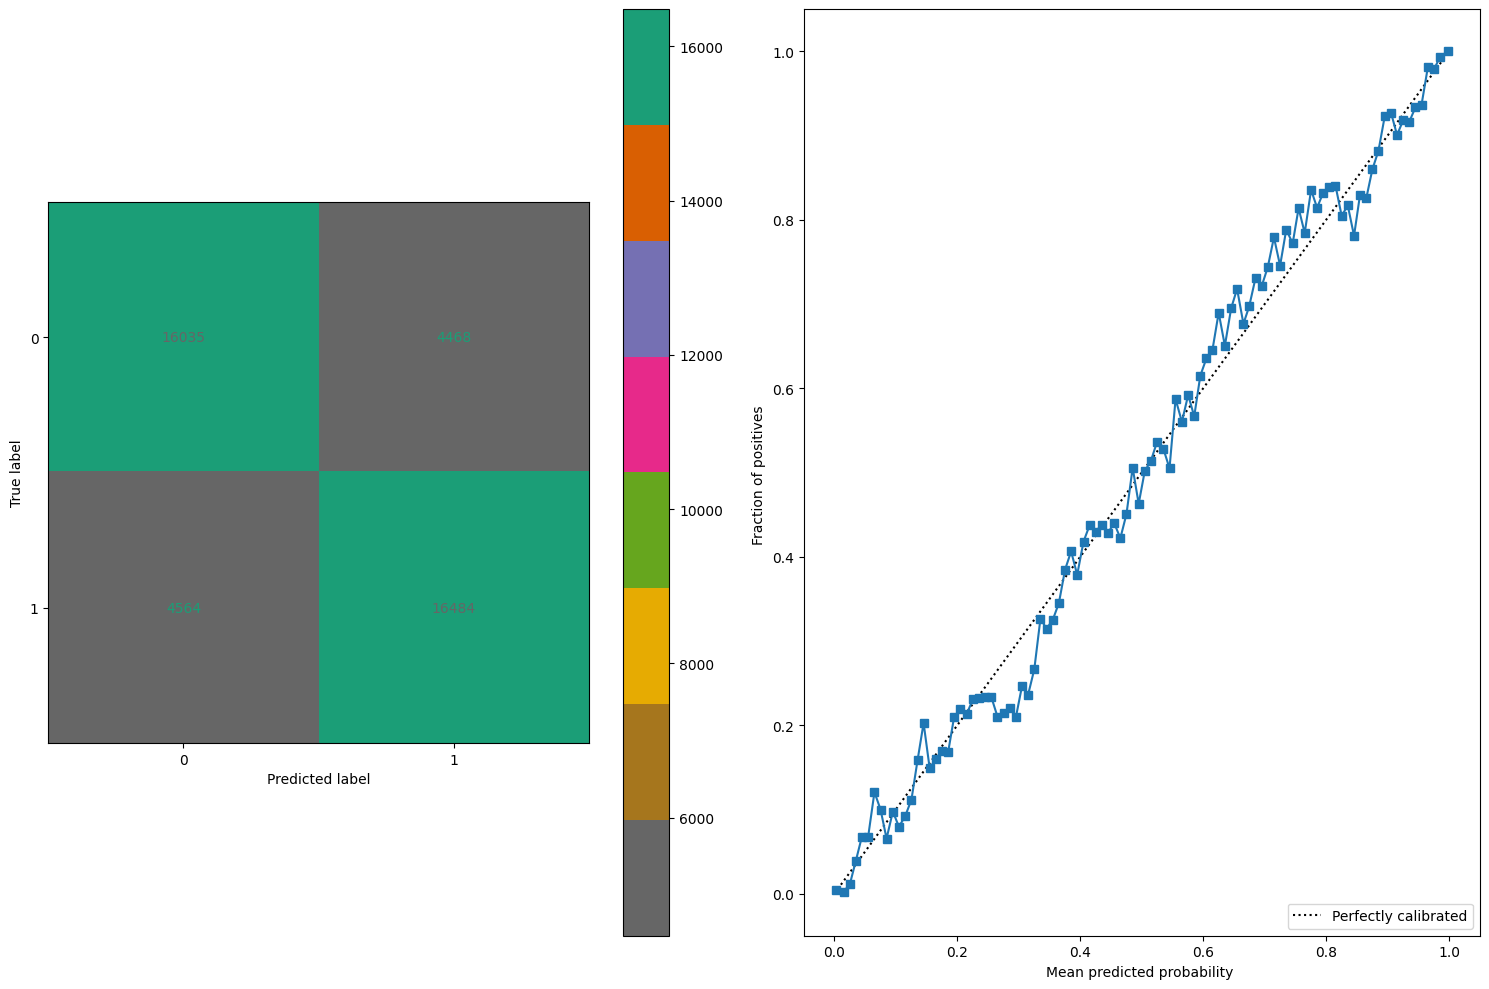

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
cm = confusion_matrix(pred_results['label'], pred_results['pred_label'])
ConfusionMatrixDisplay(cm).plot(cmap='Dark2_r', ax=ax[0])

prob_true, prob_pred = calibration_curve(pred_results['label'], pred_results['wp'], n_bins=100)
CalibrationDisplay(prob_true, prob_pred, pred_results['wp']).plot(ax=ax[1])

plt.tight_layout()
plt.show()

### Model 1 Results

Before we can analyze the confusion matrix, we need to understand what the `label` values mean:

- 1: Home team won the game
- 0: Home team lost the game

With that out of the way, we can now infer the following:

1. The model made 41551 predictions in total.
2. The model predicted that the home team would win 20952 times.  Of those predictions, 16484 were correct, and 4468 were incorrect. (78.6% accuracy; 21.4% Type 1 rate)
3. The model predicted that the home team would lose 20599 times.  Of those predictions, 16035 were correct, and 4564 were incorrect. (77.8% accuracy; 22.2% Type 2 rate)
4. Overall, the model had an accuracy of 78.2%, and an error rate of 21.8%.
5. The model had a log loss of 0.44992.
6. Cross validation took 85 seconds to complete, and model training took 6 seconds to complete.

The calibration curve shows that there is room for optimization, which can be achieved through hyperparameter tuning.

## Model 2: Hyperparameter Tuning

First, we'll save the calibration data to a CSV, then we'll create an objective function that will be used by optuna to find the best hyperparameters for the model.

In [25]:
cal_data.to_csv('tests/validation/calibration_data/wp_cal_data.csv', index=False)

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GroupKFold

def objective(trial):

    num_boosted_rounds = 15000
    early_stopping_rounds = 50
    
    monotone_contraints_df = {
        'receive_2h_ko': 0,
        'spread_time': 0,
        'home': 0,
        'half_seconds_remaining': 0,
        'game_seconds_remaining': 0,
        'Diff_Time_Ratio': 1,
        'score_differential': 1,
        'down': -1,
        'ydstogo': -1,
        'yardline_100': -1,
        'posteam_timeouts_remaining': 1,
        'defteam_timeouts_remaining': -1
    }

    wp_model_parameters = {
        'booster': 'gbtree',
        'device': 'cuda',
        'objective': 'binary:logistic',
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'sampling_method': 'gradient_based',
        'eval_metric': 'logloss',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'eta': trial.suggest_float('eta', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 1e-1, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 1e-1, 1.0),
        'max_depth': int(trial.suggest_int('max_depth', 1, 10)),
        'max_delta_step': trial.suggest_int('max_delta_step', 1, 10),
        'min_child_weight': int(trial.suggest_int('min_child_weight', 1, 20)),
        'monotone_constraints': monotone_contraints_df,
        'num_parallel_tree': 2
    }
    
    cal_data = pd.read_csv('tests/validation/calibration_data/wp_cal_data.csv')
    
    X = cal_data.loc[:, ~cal_data.columns.isin(['season', 'game_id', 'label'])]
    y = cal_data['label']
    groups = cal_data['game_id']
    
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'test-logloss')
    
    dtrain = xgb.DMatrix(X, label=y)
    folds = [(train_idx, test_idx) for train_idx, test_idx in GroupKFold(n_splits=10).split(X, y, groups=groups)]

    try:
        cv_results = xgb.cv(
            params=wp_model_parameters, 
            dtrain=dtrain, 
            num_boost_round=num_boosted_rounds, 
            stratified=trial.suggest_categorical('stratified', ['True', 'False']), 
            folds=folds, 
            callbacks=[pruning_callback],
            maximize=False, 
            early_stopping_rounds=early_stopping_rounds,
            shuffle=trial.suggest_categorical('shuffle', ['True', 'False']),
            seed=42,
            verbose_eval=500
        )
        if trial.should_prune():
            del X, y, dtrain, folds, cv_results
            raise optuna.TrialPruned()
    except Exception as e:
        del X, y, dtrain, folds
        raise e from None
             
    eval_score = cv_results['test-logloss-mean'].min()
    
    del X, y, dtrain, folds, cv_results
    
    return eval_score

Then we'll create a study and optimize the objective function:

In [2]:
import optuna

study_name = "wp_model_optimization"

storage_name = f"sqlite:///{study_name}.db"

study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", load_if_exists=True, pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=100))

[I 2024-02-13 11:13:44,128] Using an existing study with name 'wp_model_optimization' instead of creating a new one.


In [3]:
study.optimize(objective, n_trials=5)

[0]	train-logloss:0.66847+0.00021	test-logloss:0.66858+0.00066
[216]	train-logloss:0.44115+0.00125	test-logloss:0.44924+0.01119


[I 2024-02-13 11:17:10,229] Trial 125 finished with value: 0.44906588221325744 and parameters: {'grow_policy': 'lossguide', 'lambda': 4.431624397693059e-07, 'alpha': 6.641440143136634e-05, 'eta': 0.09949705996655137, 'subsample': 0.4477578360046435, 'gamma': 0.02230762915834122, 'colsample_bytree': 0.6757378028579412, 'max_depth': 6, 'max_delta_step': 7, 'min_child_weight': 7, 'stratified': 'True', 'shuffle': 'True'}. Best is trial 66 with value: 0.4486973853842214.


[0]	train-logloss:0.62624+0.00058	test-logloss:0.62646+0.00191
[116]	train-logloss:0.44213+0.00124	test-logloss:0.44951+0.01124


[I 2024-02-13 11:18:45,654] Trial 126 finished with value: 0.4491341565322669 and parameters: {'grow_policy': 'lossguide', 'lambda': 2.964850702670373e-07, 'alpha': 1.0081650845635624e-05, 'eta': 0.2999423452113917, 'subsample': 0.4071251872570535, 'gamma': 0.14317598126480938, 'colsample_bytree': 0.6382302196240218, 'max_depth': 5, 'max_delta_step': 7, 'min_child_weight': 6, 'stratified': 'True', 'shuffle': 'True'}. Best is trial 66 with value: 0.4486973853842214.


[0]	train-logloss:0.64339+0.00044	test-logloss:0.64354+0.00136
[142]	train-logloss:0.44209+0.00118	test-logloss:0.44934+0.01125


[I 2024-02-13 11:20:42,971] Trial 127 finished with value: 0.44905535912308536 and parameters: {'grow_policy': 'lossguide', 'lambda': 3.8505206479595654e-07, 'alpha': 0.00013101851117351112, 'eta': 0.21418054547024504, 'subsample': 0.4255784788937125, 'gamma': 0.046264350359323164, 'colsample_bytree': 0.7084315767880827, 'max_depth': 5, 'max_delta_step': 6, 'min_child_weight': 7, 'stratified': 'True', 'shuffle': 'True'}. Best is trial 66 with value: 0.4486973853842214.


[0]	train-logloss:0.63774+0.00089	test-logloss:0.63833+0.00464
[110]	train-logloss:0.44318+0.00122	test-logloss:0.45053+0.01134


[I 2024-02-13 11:22:02,085] Trial 128 finished with value: 0.4498990110772441 and parameters: {'grow_policy': 'depthwise', 'lambda': 8.334149809542873e-07, 'alpha': 2.3449082243786527e-05, 'eta': 0.6009344900005495, 'subsample': 0.31042023491092297, 'gamma': 0.09422042145063045, 'colsample_bytree': 0.40738725250685726, 'max_depth': 5, 'max_delta_step': 7, 'min_child_weight': 8, 'stratified': 'True', 'shuffle': 'True'}. Best is trial 66 with value: 0.4486973853842214.


[0]	train-logloss:0.67920+0.00023	test-logloss:0.67927+0.00087


[I 2024-02-13 11:23:15,360] Trial 129 pruned. Trial was pruned at iteration 100.


And the best trial in the study is:

In [4]:
best_trial = study.best_trial
best_trial.values

[0.4486973853842214]

In [5]:
best_params = study.best_params
best_params

{'grow_policy': 'depthwise',
 'lambda': 0.00010906017721218129,
 'alpha': 1.9840577413731188e-08,
 'eta': 0.1132858308757374,
 'subsample': 0.4188211822205071,
 'gamma': 0.09237567999927712,
 'colsample_bytree': 0.6676900448670713,
 'max_depth': 3,
 'max_delta_step': 7,
 'min_child_weight': 12,
 'stratified': 'False',
 'shuffle': 'True'}

Let's look at the visualizations from optuna to further analyze the study results:

In [7]:
optuna.visualization.plot_optimization_history(study)

In [8]:
optuna.visualization.plot_param_importances(study)

In [10]:
optuna.visualization.plot_parallel_coordinate(study)

In [16]:
optuna.visualization.plot_slice(study)

Let's use the best trial's parameters to train the model and test it against the 2023 season:

In [19]:
monotone_contraints_df = {
    'receive_2h_ko': 0,
    'spread_time': 0,
    'home': 0,
    'half_seconds_remaining': 0,
    'game_seconds_remaining': 0,
    'Diff_Time_Ratio': 1,
    'score_differential': 1,
    'down': -1,
    'ydstogo': -1,
    'yardline_100': -1,
    'posteam_timeouts_remaining': 1,
    'defteam_timeouts_remaining': -1
}

params = {
    'booster': 'gbtree',
    'device': 'cuda',
    'objective': 'binary:logistic',
    'grow_policy': best_params['grow_policy'],
    'sampling_method': 'gradient_based',
    'eval_metric': 'logloss',
    'lambda': best_params['lambda'],
    'alpha': best_params['alpha'],
    'eta': best_params['eta'],
    'subsample': best_params['subsample'],
    'gamma': best_params['gamma'],
    'colsample_bytree': best_params['colsample_bytree'],
    'max_depth': best_params['max_depth'],
    'max_delta_step': best_params['max_delta_step'],
    'min_child_weight': best_params['min_child_weight'],
    'monotone_constraints': monotone_contraints_df,
    'num_parallel_tree': 2
}

cal_data = pd.read_csv('tests/validation/calibration_data/wp_cal_data.csv')

train_data = cal_data.loc[cal_data['season'] < 2023]
test_data = cal_data.loc[cal_data['season'] == 2023]

dtrain = xgb.DMatrix(train_data.loc[:, ~train_data.columns.isin(['season', 'game_id', 'label'])], label=train_data['label'])
dtest = xgb.DMatrix(test_data.loc[:, ~test_data.columns.isin(['season', 'game_id', 'label'])], label=test_data['label'])

bst = xgb.train(params=params, dtrain=dtrain, num_boost_round=10000, early_stopping_rounds=50, maximize=False, verbose_eval=100, evals=[(dtest, 'season2023')])

[0]	season2023-logloss:0.66655
[100]	season2023-logloss:0.44993
[200]	season2023-logloss:0.44871
[258]	season2023-logloss:0.44905


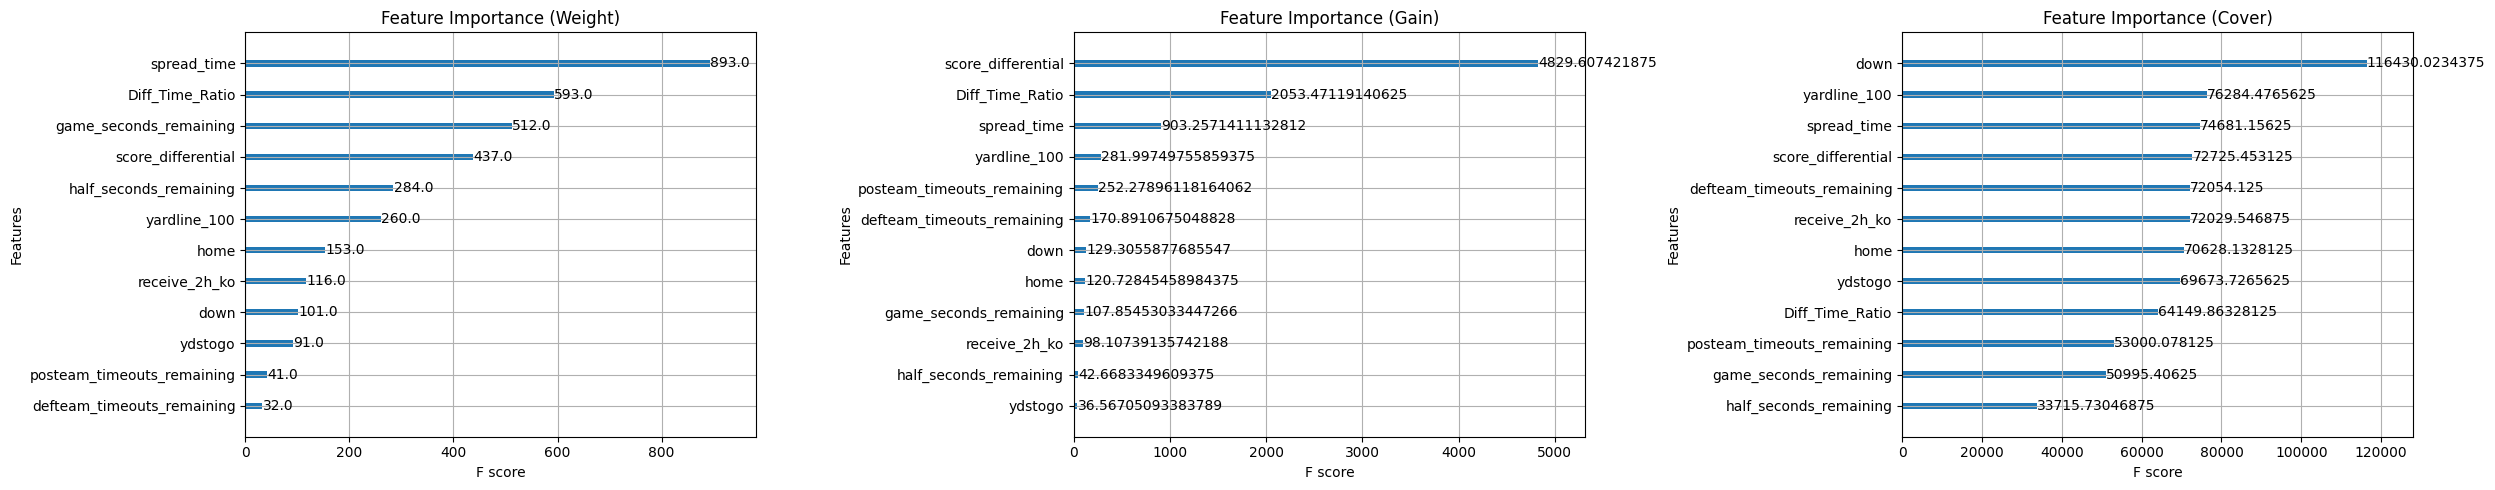

In [20]:
from matplotlib import pyplot as plt

xgb_plot = xgb.plot_importance

fig, ax = plt.subplots(1, 3, figsize=(25, 5))

xgb_plot(bst, importance_type='weight', ax=ax[0], title='Feature Importance (Weight)')
xgb_plot(bst, importance_type='gain', ax=ax[1], title='Feature Importance (Gain)')
xgb_plot(bst, importance_type='cover', ax=ax[2], title='Feature Importance (Cover)')

plt.tight_layout()

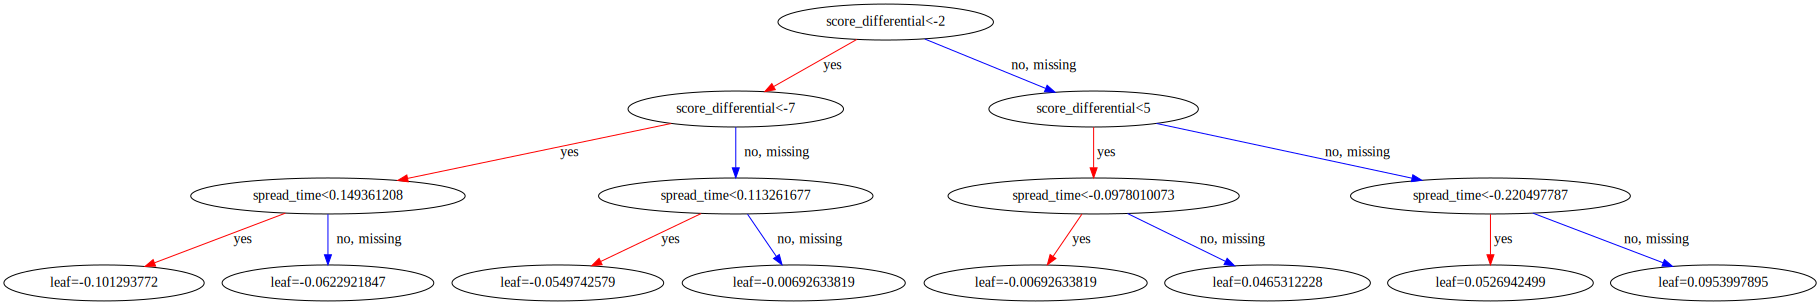

In [21]:
xgb.to_graphviz(bst)

In [23]:
import numpy as np

pred_results = test_data[['game_id', 'label', 'score_differential']].copy()
pred_results['wp'] = bst.predict(dtest)
pred_results['pred_label'] = np.where(pred_results['wp'] > 0.5, 1, 0)
pred_results['margin'] = bst.predict(dtest, output_margin=True, pred_leaf=False, pred_contribs=False, approx_contribs=False, pred_interactions=False)
pred_leaf = bst.predict(dtest, output_margin=False, pred_leaf=True, pred_contribs=False, approx_contribs=False, pred_interactions=False)

pred_contrib = bst.predict(dtest, output_margin=False, pred_leaf=False, pred_contribs=True, approx_contribs=False, pred_interactions=False)
pred_interactions = bst.predict(dtest, output_margin=False, pred_leaf=False, pred_contribs=False, approx_contribs=False, pred_interactions=True)

pred_results

,game_id,label,score_differential,wp,pred_label,margin
946138,2023_01_ARI_WAS,1,0.0,0.738689,1,1.039167
946139,2023_01_ARI_WAS,1,0.0,0.699447,1,0.844666
946140,2023_01_ARI_WAS,1,0.0,0.717830,1,0.933725
946141,2023_01_ARI_WAS,1,0.0,0.728091,1,0.984958
946142,2023_01_ARI_WAS,1,0.0,0.717025,1,0.929751
...,...,...,...,...,...,...
987684,2023_21_KC_BAL,1,7.0,0.934698,1,2.661200
987685,2023_21_KC_BAL,1,7.0,0.944887,1,2.841677
987686,2023_21_KC_BAL,1,7.0,0.987104,1,4.337832
987687,2023_21_KC_BAL,1,7.0,0.988880,1,4.487803


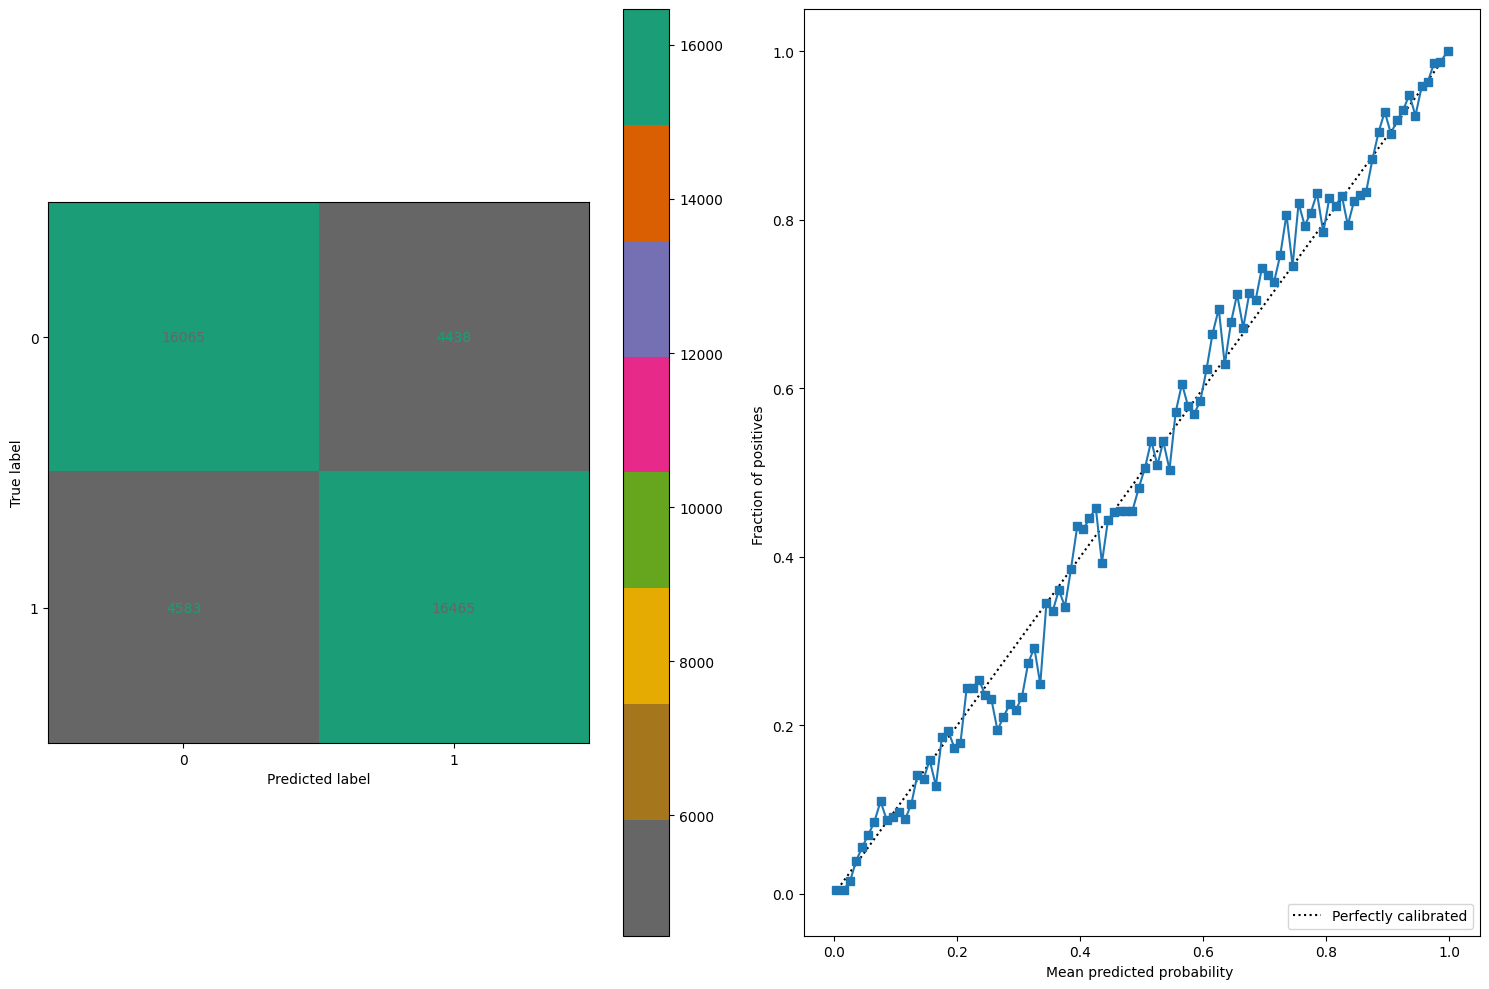

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve, CalibrationDisplay

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
cm = confusion_matrix(pred_results['label'], pred_results['pred_label'])
ConfusionMatrixDisplay(cm).plot(cmap='Dark2_r', ax=ax[0])

prob_true, prob_pred = calibration_curve(pred_results['label'], pred_results['wp'], n_bins=100)
CalibrationDisplay(prob_true, prob_pred, pred_results['wp']).plot(ax=ax[1])

plt.tight_layout()
plt.show()

### Model 2 Results

1. The model made 41551 predictions in total.
2. The model predicted that the home team would win 20903 times.  Of those predictions, 16465 were correct, and 4438 were incorrect. (78.7% accuracy; 21.3% Type 1 rate)
3. The model predicted that the home team would lose 20648 times.  Of those predictions, 16065 were correct, and 4583 were incorrect. (77.8% accuracy; 22.2% Type 2 rate)
4. Overall, the model had an accuracy of 78.2%, and an error rate of 21.8%.
5. The model had a log loss of 0.4489.
6. Hyperparameter tuning takes hours to complete, but model training took 5 seconds to complete.

## Conclusion

This exploratory analysis serves as a preliminary step towards creating a robust and reliable NFL win probability model. The adaptation from R to Python and the transition to the Scikit-Learn API interface of XGBoost demonstrates the flexibility and potential of the model in different environments.

The models tested showed varying levels of performance. The original author's model achieved a log loss of 0.44787 without a monotone constraint on spread_time and 0.44826 with it. Comparatively, my model demonstrated log loss score of 0.4488 when tuned.  The model is good enough to continue forward with further refinement in the future.
 
## References

1. Sebastian Carl, & Ron Yurko. (2021). Creating a Model from Scratch Using XGBoost in R. Open Source Football. https://opensourcefootball.com/posts/2021-04-13-creating-a-model-from-scratch-using-xgboost-in-r/#model-evaluation
2. Benjamin Robinson, & Sebastian Carl. (2020). NFLfastr: EP, WP, and CP Models. Open Source Football. https://opensourcefootball.com/posts/2020-09-28-nflfastr-ep-wp-and-cp-models/
3. nflverse Project. https://nflverse.nflverse.com/